In [2]:
# keras.losses.mean_squared_error(y_true, y_pred)
# keras.losses.mean_absolute_error(y_true, y_pred)
# keras.losses.mean_absolute_percentage_error(y_true, y_pred)
# keras.losses.mean_squared_logarithmic_error(y_true, y_pred)
# keras.losses.squared_hinge(y_true, y_pred)
# keras.losses.hinge(y_true, y_pred)
# keras.losses.categorical_hinge(y_true, y_pred)
# keras.losses.logcosh(y_true, y_pred)
# keras.losses.categorical_crossentropy(y_true, y_pred)
# keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
# keras.losses.binary_crossentropy(y_true, y_pred)
# keras.losses.kullback_leibler_divergence(y_true, y_pred)
# keras.losses.poisson(y_true, y_pred)
# keras.losses.cosine_proximity(y_true, y_pred)

In [3]:
img_rows = 512
img_cols = 512
img_slcs = 284
img1_file = './pvc_data/multi-modality_brain_1\subj01_t1bravo__pveseg.nii.gz'
img2_file = './pvc_data/multi-modality_brain_1\subj01_pet.nii.gz'
# pet_norm_file = './pvc_data/multi-modality_brain_1\subj01_pet_norm.nii.gz'
weightfile_name = 'weights_pvc.h5'
modelfile_name = 'model_pvc.h5'

In [24]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)

def mean_squared_error_custom2(y_true, y_pred):
    
    # [PET, Gray, White, CSF]
    weight = [1,1,1,1]
    
    k1 = np.array([[-1,-1,-1],
                   [0, 0, 0],
                   [1, 1, 1]], dtype=np.float32)
    k2 = np.array([[-1,0,1],
                   [-1,0,1],
                   [-1,0,1]], dtype=np.float32)
    k1 = K.reshape(k1,(3,3,1,1))
    k2 = K.reshape(k2,(3,3,1,1))
    pet_true = K.reshape(y_true[:,:,:,0], (1,512,512,1))
    pet_pred = K.reshape(y_pred[:,:,:,0], (1,512,512,1))
    norm1 = K.conv2d(pet_true, k1, strides=(1, 1), padding='same', dilation_rate=(1,1))
    norm2 = K.conv2d(pet_true, k2, strides=(1, 1), padding='same', dilation_rate=(1,1))
#     grads = K.sqrt(K.square(norm1) + K.square(norm2))
    
    pet_error = K.mean(K.square(y_pred[:,:,:,0] - y_true[:,:,:,0]), axis=-1)
#     pet_error = K.mean(K.square(y_pred[:,:,:,0] - y_true[:,:,:,0]), axis=-1)*((-grads)/3500 + 10)
    
#     pet_loss = mean_squared_error(pet_true, pet_pred)

    csf_mask = y_true[:,:,:,1]
    csf_true = csf_mask * y_true[:,:,:,0]
    csf_pred = csf_mask * y_pred[:,:,:,0]
#     csf_error = K.mean(K.square(csf_pred - csf_true), axis=-1)
    csf_error = K.max( K.square(csf_pred) ) - K.mean( K.square(csf_true) )

    gm_mask = y_true[:,:,:,2]
    gm_true = gm_mask * y_true[:,:,:,0]
    gm_pred = gm_mask * y_pred[:,:,:,0]
    gm_error = K.mean(K.square(gm_pred - gm_true), axis=-1)

    wm_mask = y_true[:,:,:,3]
    wm_maks = np.bitwise_and(wm_mask==1, y_true[:,:,:,0]<(20/35))
    wm_true = wm_mask * y_true[:,:,:,0]
    wm_pred = wm_mask * y_pred[:,:,:,0]
    #wm_sum = K.sum( wm_pred, axis=-1 )
#     wm_error = K.mean(K.square(wm_pred - wm_true), axis=-1)
    wm_error = K.max( K.square(wm_pred) ) - K.mean( K.square(wm_true) )
    return pet_error*weight[0] + gm_error*weight[1] + wm_error*weight[2] + csf_error*weight[3]

In [1]:
def l1_reg(weight_matrix):
    return 0.01 * K.sum(K.abs(weight_matrix))

def sum_reg(output):
    delta = K.sum(output[:,:,:,0]) - TOTAL_ENERGY
    return K.square(delta/(512*512))

In [30]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization

'''
U-Net: Convolutional Networks for Biomedical Image Segmentation
(https://arxiv.org/abs/1505.04597)
---
img_shape: (height, width, channels)
out_ch: number of output channels
start_ch: number of channels of the first conv
depth: zero indexed depth of the U-structure
inc_rate: rate at which the conv channels will increase
activation: activation function after convolutions
dropout: amount of dropout in the contracting part
batchnorm: adds Batch Normalization if true
maxpool: use strided conv instead of maxpooling if false
upconv: use transposed conv instead of upsamping + conv if false
residual: add residual connections around each conv block if true
'''

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
# 	o = Dense(out_ch, input_dim=out_ch, activity_regularizer=sum_reg)(o)
#     o = Dense(64, input_dim=64, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01))(o)
	return Model(inputs=i, outputs=o)

In [31]:
def train():
    
    np.random.seed(813) 

    print('-'*50)
    print('Creating and compiling network...')
    print('-'*50)

    model = UNet([img_rows,img_cols,4],out_ch=4,start_ch=16,depth=4,inc_rate=2.,activation='relu',dropout=0.5,batchnorm=True,maxpool=True,upconv=True,residual=False)

    model.compile(optimizer=Adam(lr=1e-4), loss=mean_squared_error_custom2, metrics=[mean_squared_error,mean_absolute_error])
    save_model( model, modelfile_name )

    model.summary()

    fig = plt.figure(figsize=(15,5))
    fig.show(False)

    curr_img1_nii = nibabel.load(img1_file)
    curr_img2_nii = nibabel.load(img2_file)

    curr_img1 = curr_img1_nii.get_data()
    curr_img2 = curr_img2_nii.get_data()
    

    # for PET
    curr_img2 /= 35000

    for it in tqdm(range(0,2000)):
        X = np.zeros( (1, img_rows, img_cols, 4) )
        Y = np.zeros( (1, img_rows, img_cols, 4) )

        X[0,:,:,0] = curr_img2[:,:,142]
        X[0,:,:,1] = curr_img1[:,:,142] == 1
        X[0,:,:,2] = curr_img1[:,:,142] == 2
        X[0,:,:,3] = curr_img1[:,:,142] == 3
        #X[0,:,:,1] = curr_img1[:,:,142,0]
        #X[0,:,:,2] = curr_img1[:,:,142,1]
        #X[0,:,:,3] = curr_img1[:,:,142,2]

        Y = X

        curr_losses = model.train_on_batch(X,Y)

        if it % 50 == 0:
            fig.clf()
            a = fig.add_subplot(1, 3, 1)
            plt.imshow(np.rot90(X[0,:,:,0]),cmap='gray')
            a.axis('off')
            a.set_title('X')
            a = fig.add_subplot(1, 3, 2)
            plt.imshow(np.rot90(Y[0,:,:,0]),cmap='gray')
            a.axis('off')
            a.set_title('Y')
            Y_ = model.predict( X )
            a = fig.add_subplot(1, 3, 3)
            plt.imshow(np.rot90(Y_[0,:,:,0]),cmap='gray')
            a.axis('off')
            a.set_title('\^Y')
            fig.tight_layout()
            fig.canvas.draw()
            fig.savefig('progress_dip_{0:05d}.jpg'.format(it))
            fig.canvas.flush_events()

--------------------------------------------------
Creating and compiling network...
--------------------------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 512, 512, 16) 592         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 512, 512, 16) 64          conv2d_116[0][0]                 
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 512, 512, 16) 2320        batch_n





  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]



  0%|                                                                               | 1/2000 [00:10<5:44:52, 10.35s/it]



  0%|                                                                               | 2/2000 [00:10<4:02:20,  7.28s/it]



  0%|                                                                               | 3/2000 [00:10<2:50:34,  5.12s/it]



  0%|▏                                                                              | 5/2000 [00:10<2:00:13,  3.62s/it]



  0%|▎                                                                              | 7/2000 [00:10<1:24:59,  2.56s/it]



  0%|▎                                                                              | 8/2000 [00:11<1:00:28,  1.82s/it]



  0%|▎                                                                                | 9/2000 [00:11<43:23,  1.31s/it]



  1%|▍      

 13%|██████████▏                                                                    | 257/2000 [00:35<03:08,  9.26it/s]



 13%|██████████▏                                                                    | 259/2000 [00:36<03:00,  9.64it/s]



 13%|██████████▎                                                                    | 261/2000 [00:36<02:55,  9.91it/s]



 13%|██████████▍                                                                    | 263/2000 [00:36<02:51, 10.10it/s]



 13%|██████████▍                                                                    | 265/2000 [00:36<02:48, 10.28it/s]



 13%|██████████▌                                                                    | 267/2000 [00:36<02:47, 10.35it/s]



 13%|██████████▋                                                                    | 269/2000 [00:36<02:46, 10.42it/s]



 14%|██████████▋                                                                    | 271/2000 [00:37<02:45, 10.46it/s]



 14%|██████████▊

 24%|███████████████████▎                                                           | 490/2000 [01:00<02:24, 10.45it/s]



 25%|███████████████████▍                                                           | 492/2000 [01:00<02:26, 10.30it/s]



 25%|███████████████████▌                                                           | 494/2000 [01:00<02:25, 10.35it/s]



 25%|███████████████████▌                                                           | 496/2000 [01:00<02:23, 10.45it/s]



 25%|███████████████████▋                                                           | 498/2000 [01:00<02:23, 10.50it/s]



 25%|███████████████████▊                                                           | 500/2000 [01:01<02:22, 10.51it/s]



 25%|███████████████████▊                                                           | 502/2000 [01:01<03:18,  7.56it/s]



 25%|███████████████████▉                                                           | 504/2000 [01:01<02:59,  8.34it/s]



 25%|███████████

 38%|█████████████████████████████▋                                                 | 751/2000 [01:26<02:45,  7.56it/s]



 38%|█████████████████████████████▋                                                 | 753/2000 [01:26<02:31,  8.25it/s]



 38%|█████████████████████████████▊                                                 | 755/2000 [01:26<02:20,  8.88it/s]



 38%|█████████████████████████████▉                                                 | 757/2000 [01:27<02:12,  9.36it/s]



 38%|█████████████████████████████▉                                                 | 759/2000 [01:27<02:07,  9.72it/s]



 38%|██████████████████████████████                                                 | 761/2000 [01:27<02:04,  9.97it/s]



 38%|██████████████████████████████▏                                                | 763/2000 [01:27<02:00, 10.23it/s]



 38%|██████████████████████████████▏                                                | 765/2000 [01:27<01:58, 10.44it/s]



 38%|███████████

 51%|███████████████████████████████████████▌                                      | 1015/2000 [01:52<01:35, 10.30it/s]



 51%|███████████████████████████████████████▋                                      | 1017/2000 [01:52<01:35, 10.25it/s]



 51%|███████████████████████████████████████▋                                      | 1019/2000 [01:53<01:37, 10.10it/s]



 51%|███████████████████████████████████████▊                                      | 1021/2000 [01:53<01:35, 10.27it/s]



 51%|███████████████████████████████████████▉                                      | 1023/2000 [01:53<01:34, 10.34it/s]



 51%|███████████████████████████████████████▉                                      | 1025/2000 [01:53<01:34, 10.36it/s]



 51%|████████████████████████████████████████                                      | 1027/2000 [01:53<01:33, 10.43it/s]



 51%|████████████████████████████████████████▏                                     | 1029/2000 [01:54<01:33, 10.44it/s]



 52%|███████████

 64%|█████████████████████████████████████████████████▌                            | 1272/2000 [02:18<01:09, 10.54it/s]



 64%|█████████████████████████████████████████████████▋                            | 1274/2000 [02:18<01:08, 10.62it/s]



 64%|█████████████████████████████████████████████████▊                            | 1276/2000 [02:18<01:08, 10.57it/s]



 64%|█████████████████████████████████████████████████▊                            | 1278/2000 [02:19<01:07, 10.62it/s]



 64%|█████████████████████████████████████████████████▉                            | 1280/2000 [02:19<01:07, 10.61it/s]



 64%|█████████████████████████████████████████████████▉                            | 1282/2000 [02:19<01:08, 10.43it/s]



 64%|██████████████████████████████████████████████████                            | 1284/2000 [02:19<01:07, 10.58it/s]



 64%|██████████████████████████████████████████████████▏                           | 1286/2000 [02:19<01:08, 10.43it/s]



 64%|███████████

 75%|██████████████████████████████████████████████████████████▊                   | 1508/2000 [02:42<01:00,  8.19it/s]



 75%|██████████████████████████████████████████████████████████▊                   | 1509/2000 [02:42<00:58,  8.43it/s]



 76%|██████████████████████████████████████████████████████████▉                   | 1511/2000 [02:42<00:54,  8.99it/s]



 76%|██████████████████████████████████████████████████████████▉                   | 1512/2000 [02:42<00:53,  9.09it/s]



 76%|███████████████████████████████████████████████████████████                   | 1514/2000 [02:43<00:51,  9.46it/s]



 76%|███████████████████████████████████████████████████████████                   | 1515/2000 [02:43<00:52,  9.28it/s]



 76%|███████████████████████████████████████████████████████████▏                  | 1517/2000 [02:43<00:50,  9.63it/s]



 76%|███████████████████████████████████████████████████████████▏                  | 1518/2000 [02:43<00:51,  9.43it/s]



 76%|███████████

 88%|████████████████████████████████████████████████████████████████████▌         | 1757/2000 [03:07<00:25,  9.46it/s]



 88%|████████████████████████████████████████████████████████████████████▌         | 1759/2000 [03:07<00:24,  9.78it/s]



 88%|████████████████████████████████████████████████████████████████████▋         | 1761/2000 [03:08<00:23, 10.05it/s]



 88%|████████████████████████████████████████████████████████████████████▊         | 1763/2000 [03:08<00:23, 10.23it/s]



 88%|████████████████████████████████████████████████████████████████████▊         | 1765/2000 [03:08<00:22, 10.37it/s]



 88%|████████████████████████████████████████████████████████████████████▉         | 1767/2000 [03:08<00:22, 10.48it/s]



 88%|████████████████████████████████████████████████████████████████████▉         | 1769/2000 [03:08<00:21, 10.52it/s]



 89%|█████████████████████████████████████████████████████████████████████         | 1771/2000 [03:09<00:21, 10.47it/s]



 89%|███████████

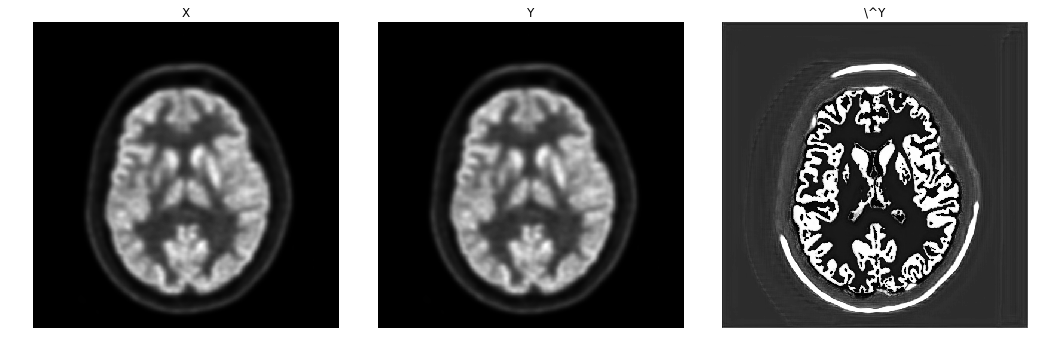

In [32]:
pet_nii = nibabel.load(img2_file)
pet_data = pet_nii.get_data()
TOTAL_ENERGY = np.sum(pet_data)

train()

In [10]:
def get_GNorm(img):
    k1 = np.array([[-1,-1,-1],
                   [0, 0, 0],
                   [1, 1, 1]])
    k2 = np.array([[-1,0,1],
                   [-1,0,1],
                   [-1,0,1]])
    
    norm1 = scipy.signal.convolve2d(img, k1, mode='same')
    norm2 = scipy.signal.convolve2d(img, k2, mode='same')
    norm = np.sqrt(norm1**2 + norm2**2)
    angel = np.arctan(norm1/norm2)
    
    return norm, angel

In [13]:
norm, angel = get_GNorm(pet_data[:,:,142])
print(np.amax(norm))

D:\WinstonChen\envs\UNet\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\WinstonChen\envs\UNet\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
D:\WinstonChen\envs\UNet\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arctan
  if sys.path[0] == '':


31410.929031611602


In [33]:
import matplotlib.pyplot as plt

In [34]:
pet_nii = nibabel.load(img2_file)
mask_nii = nibabel.load(img1_file)
pet_data = pet_nii.get_fdata()
mask_data = mask_nii.get_fdata()
y = pet_data[:,:,142]
wm = mask_data[:,:,142] == 3
# TOTAL_ENERGY = np.sum(pet_data)
print(wm.shape)

(512, 512)


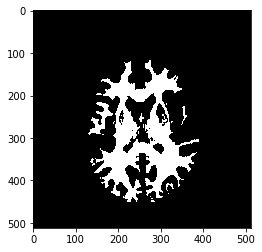

In [35]:
plt.imshow(np.rot90(wm), cmap='gray')

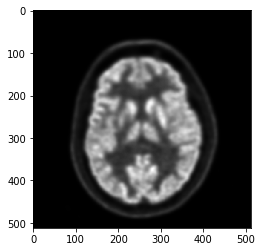

In [36]:
plt.imshow(np.rot90(y), cmap='gray')

(512, 512)


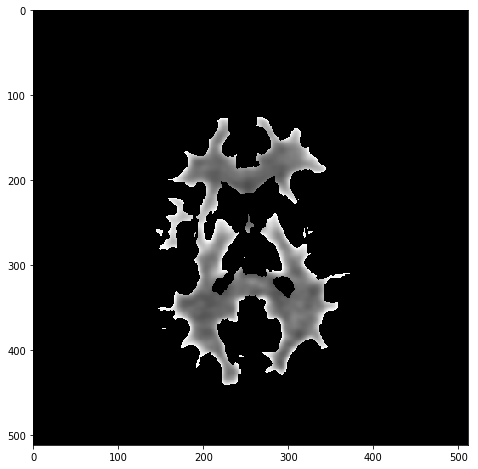

In [40]:
mix = np.bitwise_and(y<27000,wm)
mix = y*mix
print(mix.shape)
plt.figure(figsize=(8,8))
plt.imshow(np.rot90(mix), cmap='gray')

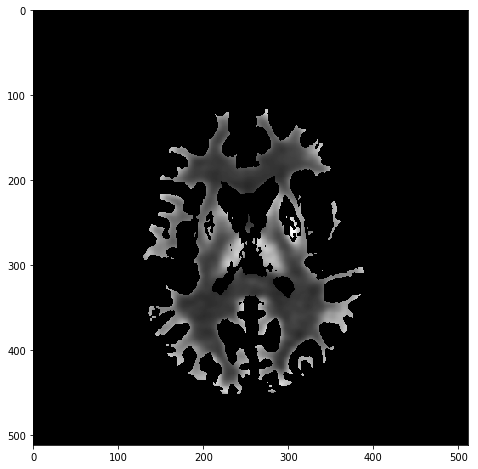

In [86]:
plt.figure(figsize=(8,8))
plt.imshow(np.rot90(y*wm), cmap='gray')

In [33]:
curr_img1_nii = nibabel.load(img1_file)
curr_img2_nii = nibabel.load(img2_file)

curr_img1 = curr_img1_nii.get_data()
curr_img2 = curr_img2_nii.get_data()

In [37]:
print(curr_img1.shape)
print(curr_img2.shape)
print(np.amax(curr_img1))
print(np.amax(curr_img2))

(512, 512, 284)
(512, 512, 284)
3
62731.21


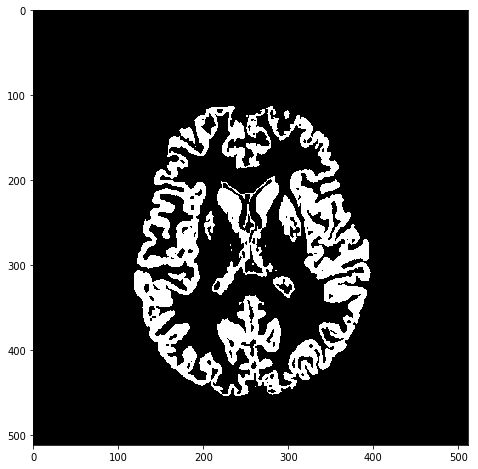

In [44]:
img = curr_img1[:,:,142] == 2
plt.figure(figsize=(8,8))
plt.imshow(np.rot90(img), cmap='gray')

In [ ]:
# if __name__ == '__main__':
#     train()